Data Bias Check

In [1]:
# imports
import pandas as pd
import numpy as np
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
import seaborn as sns

Generate data

In [39]:
df_t0 = pd.DataFrame({'gender': np.random.choice(['F','M'], 10000, p=[0.52, 0.48]),
'target': 0})
df_t1 = pd.DataFrame({'gender': np.random.choice(['F','M'], 800, p=[0.42, 0.58]),
'target': 1})
df_train = pd.concat([df_t0, df_t1], axis=0)
print(df_t0.shape)
print(df_t1.shape)

(10000, 2)
(800, 2)


Print basic information

In [45]:
def print_basic_stats(df, target_col, sensitive_attribute, text_header=''):
    def get_basic_stats(df, target_col):
        return df.shape[0], df[target_col].sum(), 100* df[target_col].sum() / df.shape[0]
    n_tot, n_1, p_1 = get_basic_stats(df, target_col)
    print(f'{text_header}: {p_1:.2f}% ({n_1:.0f}/{n_tot:.0f})')
    text_header = f"{text_header} ".lstrip()
    for sens in np.sort(df[sensitive_attribute].unique()):
        n_tot, n_1, p_1 = get_basic_stats(df.loc[df[sensitive_attribute]==sens, :], target_col)
        print(f'{text_header}{sens}: {p_1:.2f}% ({n_1:.0f}/{n_tot:.0f})')

In [46]:
sensitive_attribute = 'gender'
sensitive_attribute_label = 'gender'

print_basic_stats(df_train, 'target',  sensitive_attribute, 'train set')

train set: 7.41% (800/10800)
train set F: 6.81% (374/5488)
train set M: 8.02% (426/5312)


Prepare data for plot

In [49]:
dd = df_train
order = df_train[sensitive_attribute].unique().tolist()
qq = dd[sensitive_attribute].value_counts().rename("volume").to_frame()
qq['percentage'] = 100 * qq['volume'] / dd.shape[0]

print(f"order: {order}")
print(f"qq: {qq}")

qq = qq.join(dd.groupby(sensitive_attribute).apply(
    lambda x: pd.Series([x['target'].sum(), 
                         100 * x['target'].mean()], index=('n_target', 'target ratio'))))

qq = qq.reset_index().rename(columns={'index': sensitive_attribute_label})
qq

order: ['F', 'M']
qq:         volume  percentage
gender                    
F         5488   50.814815
M         5312   49.185185


,gender,volume,percentage,n_target,target ratio
0,F,5488,50.814815,374.0,6.814869
1,M,5312,49.185185,426.0,8.019578


Plot

In [56]:
# Functions to change plot appearance

def change_height(ax, new_value):
    for patch in ax.patches:
        current_height = patch.get_height()
        diff = current_height - new_value
        # we change the bar width
        patch.set_height(new_value)
        # we re-center the bar
        patch.set_y(patch.get_y() + diff * .5)

def show_values(axs, orient="v", space=.01, decimals=1):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = pd.get_y() + p.get_height() + (p.get_height()*0.01)
                value = (' {:.'+str(decimals)+'f} %').format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() *.5)
                value = (' {:.'+str(decimals)+'f} %').format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
    

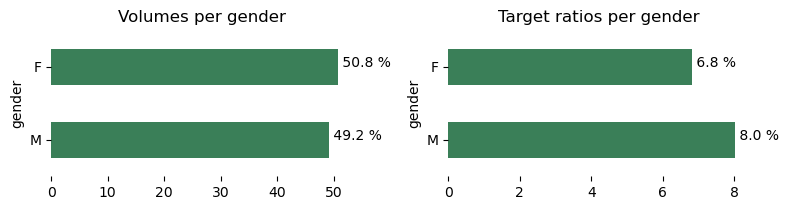

In [57]:
fig, axes = plt.subplots(1, 2, figsize= (8, 2.2))

p1 = sns.barplot(ax=axes[0], y=sensitive_attribute_label, x="percentage", data=qq, color='seagreen')
axes[0].set_title('Volumes per '+ sensitive_attribute_label)
axes[0].set_xlabel(None)

p2 = sns.barplot(ax=axes[1], y=sensitive_attribute_label, x="target ratio", data=qq, color='seagreen')
axes[1].set_title('Target ratios per '+ sensitive_attribute_label)
axes[1].set_xlabel(None)

# make bars thiner
change_height(axes[0], .5)
change_height(axes[1], .5)

# show values on barplot
show_values(p1, "h", space=0)
show_values(p2, "h", space=0)

sns.despine(left=True, bottom=True)
plt.tight_layout()